(example_4)=
# Example 4: Learning causal coupling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

```{admonition} Authors
:class: tip

- Lina Walkowiak, Aarhus University, Denmark ([202205493@post.au.dk](202205493@post.au.dk))
- Nicolas Legrand, Aarhus University, Denmark ([nicolas.legrand@cas.au.dk](nicolas.legrand@cas.au.dk))
```

In [605]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [606]:
%load_ext autoreload
%autoreload 2

from functools import partial
from typing import Callable, Dict, NamedTuple, Optional, Tuple

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax import Array, jit

from pyhgf.math import gaussian_surprise
from pyhgf.response import first_level_gaussian_surprise
from pyhgf.model.network import Network
from pyhgf.typing import Edges
from pyhgf.updates.prediction_error.continuous import continuous_node_prediction_error
from pyhgf.updates.causal_functions import (
    calculate_mutual_information,
    calculate_prediction_difference,
    calculate_surd,
    get_coupling_strength,
    update_coupling_strength_prediction_error,
    update_coupling_strength_surd,
)

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this notebook, we implement a model that incorporates causal coupling. 
We simulate two time series, where one has a causal influence on the other, where the magnitude of the influence is changing over time. The HGF model takes these two time series as inputs, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 


## Simulating a data set

We create two synthetic time series, $x_1$ and  $x_2$, where $x_1$ is an independent random walk and $x_2$ depends on $x_1$ with three varying levels of influence: strong, medium, and low. This approach allows us to model a dynamic causal relationship between the series, with dependency strengths changing in the three different phases. We add noise to each phase, with the noise level increasing and thereby the dependency weakens.

$$
\begin{align*} 
    x_1 & \sim \mathcal{N}(0.0, 0.2) \\
    x_2 & \sim \mathcal{N}(0.0, 0.2) \\
    x_2 & = x_2 + \alpha x_1
\end{align*} 
$$

In [607]:
np.random.seed(123)

# Parameters
n_samples = 10000

# Generate x_1 and x_2 as a random walk
x1 = np.cumsum(np.random.normal(0, 0.02, n_samples)) + 2.0
x2 = np.random.normal(0, 0.02, n_samples)

# Coupling vector
coupling = np.array([0.0, 0.2, 0.5, 0.5, 0.8, 1.0, 0.2, 0.8, 0.0, 1.0]).repeat(
    n_samples / 10
)

# Update x_2 so it is influenced by x_1 according to the coupling vector
x2 = x2 + coupling * x1

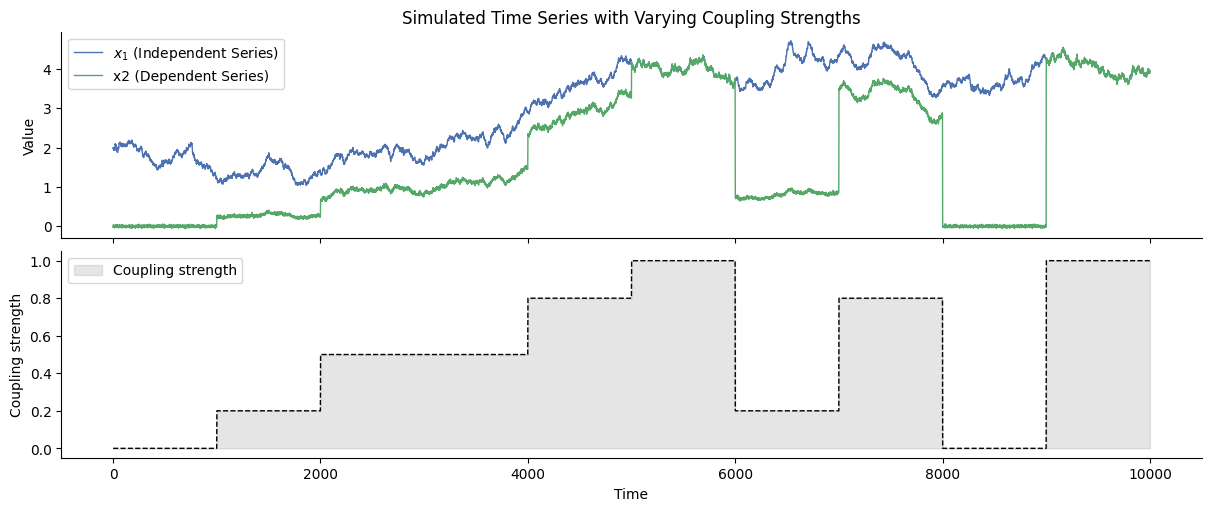

In [608]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)
axs[0].plot(x1, label=r"$x_1$ (Independent Series)", color="#4c72b0", linewidth=1)
axs[0].plot(x2, label="x2 (Dependent Series)", color="#55a868", linewidth=1)
axs[0].set(
    title="Simulated Time Series with Varying Coupling Strengths", ylabel="Value"
)
axs[0].legend()

axs[1].plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs[1].fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs[1].set(xlabel="Time", ylabel="Coupling strength")
axs[1].legend()
sns.despine();

## Creating the network

Here, we initialize one network with two input state nodes. Each state node is influenced by a value parent. The two nodes are independent of each other.

In [609]:
# Initialize two independent HGFs for X1 and X2
non_causal_hgf = (
    Network()
    .add_nodes(precision=1e1, n_nodes=2)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)

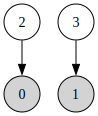

In [610]:
non_causal_hgf.plot_network()

In [611]:
# Input the time series
input_data = np.array([x1, x2]).T
non_causal_hgf.input_data(input_data=input_data);

Array(157040.83, dtype=float32)

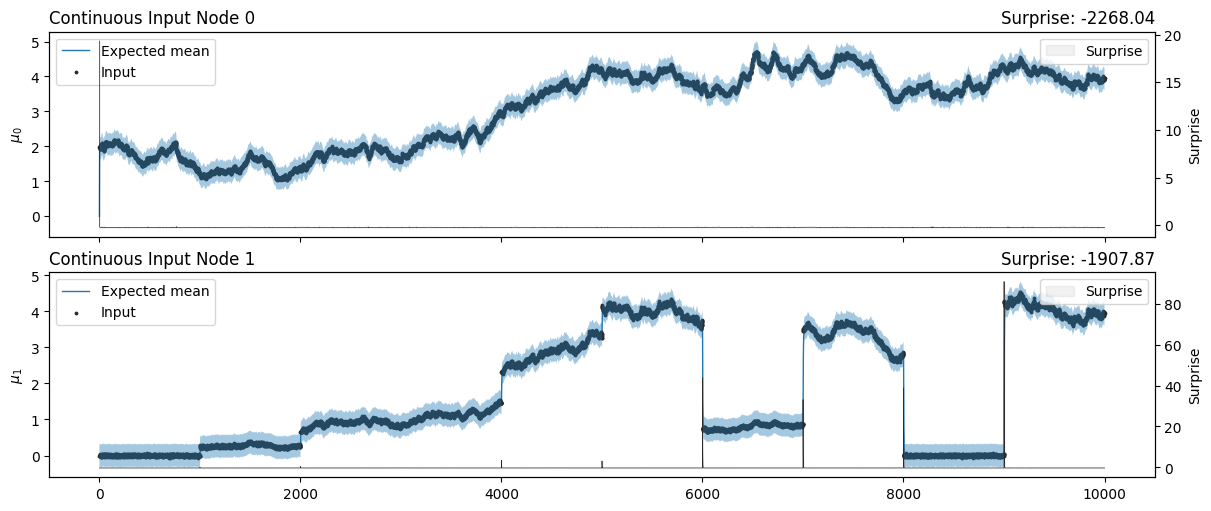

In [612]:
# Plot trajectories for each HGF
non_causal_hgf.plot_nodes(node_idxs=[0, 1]);
non_causal_hgf.surprise(response_function=first_level_gaussian_surprise).sum()


## Causal coupling model

In this section, we create a coupled HGF model to capture the causal influence of the variable $x_1$ on the variable $x_2$. This setup now implies learning the strength of a causal connection between $x_1$ and $x_2$, which should reflect the actual value used for the simulations above. We therefore use the same model as a starting point and will add an extra step in the update sequence to learn the causal coupling strength over time.

In [613]:
# Initialize a causal HGF
causal_hgf = (
    Network()
    .add_nodes(precision=1e1, n_nodes=2)
    .add_nodes(value_children=0)
    .add_nodes(value_children=1)
)

### Add a causal connection between the two nodes

In [614]:
# Add the coupling strength in the node attributes
causal_hgf.attributes[0]["causal_coupling_children"] = jnp.array([0.0])

In [615]:
# Update the edges variable so it stores the index of the causal child
edges = list(causal_hgf.edges)
adjacency_list = edges[0]

In [616]:
# Create a new adjacency variable for this case
class CausalAdjacencyLists(NamedTuple):
    node_type: int
    value_parents: Optional[Tuple]
    volatility_parents: Optional[Tuple]
    value_children: Optional[Tuple]
    volatility_children: Optional[Tuple]
    coupling_fn: Tuple[Optional[Callable], ...]
    causal_children: Optional[Tuple]


causal_adjacency_list = CausalAdjacencyLists(
    node_type=adjacency_list.node_type,
    value_parents=adjacency_list.value_parents,
    volatility_parents=adjacency_list.volatility_parents,
    value_children=adjacency_list.value_children,
    volatility_children=adjacency_list.volatility_children,
    coupling_fn=adjacency_list.coupling_fn,
    causal_children=(1,),
)

In [617]:
# Insert the new variable back to the edges
edges[0] = causal_adjacency_list
causal_hgf.edges = tuple(edges)

### Create the causal update function

Now that the variables are in place in the network, we need to create a new update function that will estimate the causal strength between the two variables at each belief propagation.

In [618]:
@partial(jit, static_argnames=("node_idx", "edges"))
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
) -> Array:
    r"""Update the causal strength between this node and all causal children.

    Parameters
    ----------
    attributes :
        The attributes of the probabilistic nodes.
    node_idx :
        Pointer to the value parent node that will be updated.

    Returns
    -------
    attributes :
        The attributes of the probabilistic nodes.

    """
    # get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_expected_precision = attributes[node_idx]["expected_precision"]

    # for all causal children, compute the new causal strength
    new_strengths = []
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):

        # get children's expected mean and precision
        child_expected_mean = attributes[causal_child_idx]["expected_mean"]
        child_expected_precision = attributes[causal_child_idx]["expected_precision"]

        child_surprise = gaussian_surprise(
            x=attributes[causal_child_idx]["mean"],
            expected_mean=child_expected_mean,
            expected_precision=child_expected_precision,
        )
        combined_surprise = gaussian_surprise(
            x=attributes[causal_child_idx]["mean"],
            expected_mean=child_expected_mean + parent_expected_mean,
            expected_precision=child_expected_precision + parent_expected_precision,
        )
        new_strengths.append(child_surprise - combined_surprise)

    # update the strengths vector
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes

### Precision weighted draft
The function adjusts causal strengths between a parent and each child node by using the prediction error weighted by the child’s precision. This weighted error thereby scales the edge strength.

Update rule for causal strength between parent node i and child node j:
$$ w_{ij}^{\text{new}} = w_{ij}^{\text{old}} + \eta \cdot \delta_j \cdot \mu_i $$
$\eta$ is the learning rate, $\delta_j$ is the precision-weighted prediction error, $\mu_i$ is the parent's mean.
Including the parent's mean in the updating rule is a way of including the state of the parent and how taht should affect the influence the parent has on the child. In other words, the causal strength update considers the magnitude of the parent’s contribution to the child's predictions. (Adding scaling factors here for relative influence)





In [619]:
def continuous_node_causal_strength(
    attributes: Dict,
    edges: Edges,
    node_idx: int,
    learning_rate: float = 0.2,
) -> Array:
    r"""Update the causal strength between this node and all causal children based on precision-weighted prediction errors.

    Parameters
    ----------
    attributes :
        The attributes of the probabilistic nodes.
    edges :
        The edges of the network.
    node_idx :
        Index of the parent node whose edges will be updated.
    learning_rate :
        The learning rate for updating the edge weights.

    Returns
    -------
    attributes :
        The updated attributes of the probabilistic nodes.

    """
    # Get the expected mean and precision from the causal parent
    parent_expected_mean = attributes[node_idx]["expected_mean"]
    parent_precision = attributes[node_idx]["expected_precision"]

    # Initialize list for new strengths
    new_strengths = []

    # Iterate over each causal child to update strengths
    for causal_child_idx, strength in zip(
        edges[node_idx].causal_children,
        attributes[node_idx]["causal_coupling_children"],
    ):

        # Calculate the value prediction error for the child
        attributes = continuous_node_prediction_error(
            attributes=attributes, node_idx=causal_child_idx, edges=edges[node_idx]
        )
        
        # Retrieve the prediction error and precision for the child
        prediction_error = attributes[causal_child_idx]["temp"]["value_prediction_error"]
        child_precision = attributes[causal_child_idx]["expected_precision"]

        # Compute precision-weighted prediction error
        precision_weighted_pe = prediction_error * child_precision

        # Update the strength for the edge between parent and child
        new_strength = strength + learning_rate *  precision_weighted_pe * parent_expected_mean
        new_strengths.append(new_strength)

    # Update causal coupling strengths for the parent node
    attributes[node_idx]["causal_coupling_children"] = jnp.array(new_strengths)

    return attributes

In [620]:
# Add this step at the end of the belief propagation sequence
# Here we simply re-use the previous sequence as template
predictions, updates = non_causal_hgf.update_sequence
updates += ((0, continuous_node_causal_strength),)
causal_hgf.update_sequence = (predictions, updates)
causal_hgf = causal_hgf.create_belief_propagation_fn()


## Fitting data and visualisation

In [621]:
causal_hgf.input_data(input_data=input_data);

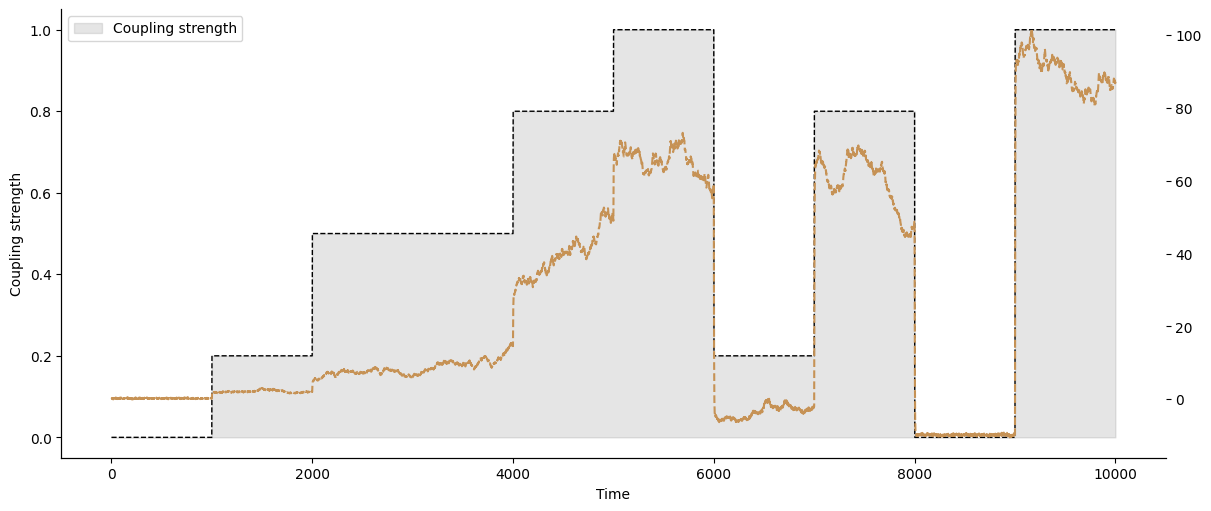

In [622]:
# Plot
_, axs = plt.subplots(figsize=(12, 5), sharex=True)

axs.plot(coupling, color="k", linestyle="--", linewidth=1.0)
axs.fill_between(
    np.arange(0, len(coupling)),
    coupling,
    color="gray",
    alpha=0.2,
    label="Coupling strength",
)
axs.set(xlabel="Time", ylabel="Coupling strength")
axs.legend()

coupling_ax = axs.twinx()
coupling_ax.plot(
    causal_hgf.node_trajectories[0]["causal_coupling_children"],
    label="Inferred coupling strength",
    color="#c69255",
    linestyle="--",
)

sns.despine();

## System configuration

In [623]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Nov 15 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

seaborn   : 0.13.2
jax       : 0.4.35
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
matplotlib: 3.9.2
numpy     : 1.26.0
pyhgf     : 0.0.0
IPython   : 8.29.0

Watermark: 2.5.0

